# Content-based Recommender System

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Loading
photos_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/photos.csv', sep=',', encoding='latin-1',low_memory=False)
ratings_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/ratings.csv', sep=',', encoding='latin-1',low_memory=False)
surveys_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/surveys.csv', sep=',', encoding='latin-1',low_memory=False)
annotations_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/annotations.csv', sep=',', encoding='latin-1',low_memory=False)

In [4]:
photos_df

,id,file_name,ext,views,id_source,source,height,width,alt
0,1,iaps_mikels_annotated-1019,jpg,0,1019,iaps_mikels_annotated,NaN,NaN,NaN
1,2,iaps_mikels_annotated-1022,jpg,11,1022,iaps_mikels_annotated,NaN,NaN,NaN
2,3,iaps_mikels_annotated-1030,jpg,0,1030,iaps_mikels_annotated,NaN,NaN,NaN
3,4,iaps_mikels_annotated-1040,jpg,0,1040,iaps_mikels_annotated,NaN,NaN,NaN
4,5,iaps_mikels_annotated-1050,jpg,0,1050,iaps_mikels_annotated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2880,3079,pexels-photo-19221067,jpeg,0,19221067,pexels,4000.0,6000.0,A black and white photo of a tank
2881,3081,pexels-photo-53442,jpeg,0,53442,pexels,2352.0,3515.0,Black Metal Train Rails
2882,3082,pexels-photo-1636162,jpeg,0,1636162,pexels,3167.0,4781.0,Brown Concrete Building
2883,3083,pexels-photo-1643166,jpeg,0,1643166,pexels,2986.0,4508.0,Leafless Trees Near the Building


# Pre-processing Pixel-based

In [5]:
# CSVs on pixel similarity from the server
# Cosine distance
pixel_sim_vgg16_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_vgg19_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_vgg19.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet50_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet50.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet50v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet50v2.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet101_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet101.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet101v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet101v2.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet152_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet152.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_sim_resnet152v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/similarity_scores_resnet152v2.csv', sep=',', encoding='latin-1',low_memory=False)

In [6]:
pixel_sim_vgg16_df

,Target Image,Comparison Image,Similarity Score
0,pexels-photo-7142950.jpeg,pexels-photo-7142950.jpeg,1.000000
1,iaps_mikels_annotated-8232.jpg,iaps_mikels_annotated-8232.jpg,1.000000
2,pexels-photo-5623160.jpeg,pexels-photo-5623160.jpeg,1.000000
3,iaps_mikels_annotated-3210.jpg,iaps_mikels_annotated-3210.jpg,1.000000
4,pexels-photo-1853951.jpeg,pexels-photo-1853951.jpeg,1.000000
...,...,...,...
4191955,pexels-photo-3756682.jpeg,pexels-photo-7952779.jpeg,0.112398
4191956,pexels-photo-6984614.jpeg,pexels-photo-7952779.jpeg,0.108610
4191957,pexels-photo-3785079.jpeg,pexels-photo-7952779.jpeg,0.106822
4191958,pexels-photo-8727540.jpeg,pexels-photo-7952779.jpeg,0.099391


In [7]:
# CSVs on pixel similarity from the server
# Euclidean distance
pixel_eu_sim_vgg16_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_vgg16.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_vgg19_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_vgg19.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet50_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet50.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet50v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet50v2.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet101_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet101.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet101v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet101v2.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet152_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet152.csv', sep=',', encoding='latin-1',low_memory=False)
pixel_eu_sim_resnet152v2_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/eu_similarity_scores_resnet152v2.csv', sep=',', encoding='latin-1',low_memory=False)

In [8]:
pixel_eu_sim_vgg16_df

,Target Image,Comparison Image,Similarity Score
0,pexels-photo-4586994.jpeg,pexels-photo-4586994.jpeg,1.000000
1,pexels-photo-4586994.jpeg,pexels-photo-6401669.jpeg,0.553053
2,pexels-photo-4586994.jpeg,pexels-photo-2341830.jpeg,0.444985
3,pexels-photo-4586994.jpeg,pexels-photo-1435904.jpeg,0.376904
4,pexels-photo-4586994.jpeg,iaps_mikels_annotated-9190.jpg,0.489843
...,...,...,...
4191955,iaps_mikels_annotated-9300.jpg,pexels-photo-1149022.jpeg,0.347414
4191956,iaps_mikels_annotated-9300.jpg,iaps_mikels_annotated-5480.jpg,0.423234
4191957,pexels-photo-1149022.jpeg,pexels-photo-1149022.jpeg,1.000000
4191958,pexels-photo-1149022.jpeg,iaps_mikels_annotated-5480.jpg,0.343480


In [9]:
# From the photos_df select only the ones that have views
photos_w_ids_df = photos_df[photos_df['views'] > 0]
photos_ids_views = photos_w_ids_df['id'].unique()
print(len(photos_df))
print(len(photos_ids_views))

2885
553


In [10]:
photos_df

,id,file_name,ext,views,id_source,source,height,width,alt
0,1,iaps_mikels_annotated-1019,jpg,0,1019,iaps_mikels_annotated,NaN,NaN,NaN
1,2,iaps_mikels_annotated-1022,jpg,11,1022,iaps_mikels_annotated,NaN,NaN,NaN
2,3,iaps_mikels_annotated-1030,jpg,0,1030,iaps_mikels_annotated,NaN,NaN,NaN
3,4,iaps_mikels_annotated-1040,jpg,0,1040,iaps_mikels_annotated,NaN,NaN,NaN
4,5,iaps_mikels_annotated-1050,jpg,0,1050,iaps_mikels_annotated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2880,3079,pexels-photo-19221067,jpeg,0,19221067,pexels,4000.0,6000.0,A black and white photo of a tank
2881,3081,pexels-photo-53442,jpeg,0,53442,pexels,2352.0,3515.0,Black Metal Train Rails
2882,3082,pexels-photo-1636162,jpeg,0,1636162,pexels,3167.0,4781.0,Brown Concrete Building
2883,3083,pexels-photo-1643166,jpeg,0,1643166,pexels,2986.0,4508.0,Leafless Trees Near the Building


In [11]:
def add_image_ids(pixel_sim_df, photos_df):
    """This function receives a dataframe that has similarity images with a file_name string and gives the id of the same image of the dataframe photos_df,

    Args:
        pixel_sim_df (pd.Dataframe): A dataframe with the columns 'Target Image', 'Comparison Image' and 'Similarity Score'
        photos_df (pd.Dataframe): a dataframe related with the photos with the following columns 'id', 'filename', 'ext', 'views', 'id_source', 'height', 'width' and 'alt'.

    Returns:
        pd.Dataframe: A dataframe with the columns 'id_target', 'id_comparison' and 'similarity_score' and the values of the columns (id_target and id_comparison) aren't the filename but the photo's id. 
    """
    # Remove the extensions of the photo's names in the pixel_sim_df
    pixel_sim_df['Target Image'] = pixel_sim_df['Target Image'].str.replace(r'\.[^.]*$', '', regex=True)
    pixel_sim_df['Comparison Image'] = pixel_sim_df['Comparison Image'].str.replace(r'\.[^.]*$', '', regex=True)

    # Merge with photos_df to get target and comparison image IDs
    merged_df = pixel_sim_df \
        .merge(photos_df[['file_name', 'id']], left_on='Target Image', right_on='file_name', how='left') \
        .merge(photos_df[['file_name', 'id']], left_on='Comparison Image', right_on='file_name', how='left', suffixes=('_target', '_comparison'))

    # Rename the columns
    result_df = merged_df[['id_target', 'id_comparison', 'Similarity Score']].rename(columns={'Similarity Score': 'similarity_score'})

    return result_df


def filter_pixel_sim_df(pixel_sim_df, photos_df):
    """Receives a dataframe from the similarities and the photos_df and returns a similarity dataframe with only the photos that have views.

    Args:
        pixel_sim_df (pd.Dataframe): A dataframe with the columns 'id_target', 'id_comparison' and 'similarity_score'. The ids must correspond to the ids in photos_df.
        photos_df (pd.Dataframe): a dataframe related with the photos with the following columns 'id', 'filename', 'ext', 'views', 'id_source', 'height', 'width' and 'alt'.

    Returns:
        pd.Dataframe: with the same columns as the pixel_sim_df but in the rows there are only photo_ids that have views.
    """
    # From the photos_df select only the items that have views
    photos_w_ids_df = photos_df[photos_df['views'] > 0]
    photos_ids_views = photos_w_ids_df['id'].unique()

    filtered_df = pixel_sim_df[
        (pixel_sim_df['id_target'].isin(photos_ids_views)) & 
        (pixel_sim_df['id_comparison'].isin(photos_ids_views))
    ]

    return filtered_df

In [12]:
# Dicionary with the dataframe name in a string and the dataframe
dataframes_info= {
    'pixel_sim_vgg16_df': pixel_sim_vgg16_df,
    'pixel_sim_vgg19_df': pixel_sim_vgg19_df,
    'pixel_sim_resnet50_df': pixel_sim_resnet50_df,
    'pixel_sim_resnet50v2_df': pixel_sim_resnet50v2_df,
    'pixel_sim_resnet101_df': pixel_sim_resnet101_df,
    'pixel_sim_resnet101v2_df': pixel_sim_resnet101v2_df,
    'pixel_sim_resnet152_df': pixel_sim_resnet152_df,
    'pixel_sim_resnet152v2_df': pixel_sim_resnet152v2_df,
    'pixel_eu_sim_vgg16_df': pixel_eu_sim_vgg16_df,
    'pixel_eu_sim_vgg19_df': pixel_eu_sim_vgg19_df,
    'pixel_eu_sim_resnet50_df': pixel_eu_sim_resnet50_df,
    'pixel_eu_sim_resnet50v2_df': pixel_eu_sim_resnet50v2_df,
    'pixel_eu_sim_resnet101_df': pixel_eu_sim_resnet101_df,
    'pixel_eu_sim_resnet101v2_df': pixel_eu_sim_resnet101v2_df,
    'pixel_eu_sim_resnet152_df': pixel_eu_sim_resnet152_df,
    'pixel_eu_sim_resnet152v2_df': pixel_eu_sim_resnet152v2_df
}

# Iterates over the dictionary, applies the functions and saves the DataFrames to CSV files
for df_name, df in dataframes_info.items():
    
    df = add_image_ids(df, photos_df) # Adds the IDs
    df = filter_pixel_sim_df(df, photos_df) # filters the dataframes for photos viewed
    df.to_csv(f'{df_name}.csv', index=False) # Saves the new dataframe in a CSV

# 1. Content-based Recommender System - Fuctions

## 1.1. Recommendation Fuctions

In [13]:
# Data loading
pixel_sim_vgg16_df = pd.read_csv('pixel_sim_vgg16_df.csv')
pixel_sim_vgg19_df = pd.read_csv('pixel_sim_vgg19_df.csv')
pixel_sim_resnet50_df = pd.read_csv('pixel_sim_resnet50_df.csv')
pixel_sim_resnet50v2_df = pd.read_csv('pixel_sim_resnet50v2_df.csv')
pixel_sim_resnet101_df = pd.read_csv('pixel_sim_resnet101_df.csv')
pixel_sim_resnet101v2_df = pd.read_csv('pixel_sim_resnet101v2_df.csv')
pixel_sim_resnet152_df = pd.read_csv('pixel_sim_resnet152_df.csv')
pixel_sim_resnet152v2_df = pd.read_csv('pixel_sim_resnet152v2_df.csv')

pixel_eu_sim_vgg16_df = pd.read_csv('pixel_eu_sim_vgg16_df.csv')
pixel_eu_sim_vgg19_df = pd.read_csv('pixel_eu_sim_vgg19_df.csv')
pixel_eu_sim_resnet50_df = pd.read_csv('pixel_eu_sim_resnet50_df.csv')
pixel_eu_sim_resnet50v2_df = pd.read_csv('pixel_eu_sim_resnet50v2_df.csv')
pixel_eu_sim_resnet101_df = pd.read_csv('pixel_eu_sim_resnet101_df.csv')
pixel_eu_sim_resnet101v2_df = pd.read_csv('pixel_eu_sim_resnet101v2_df.csv')
pixel_eu_sim_resnet152_df = pd.read_csv('pixel_eu_sim_resnet152_df.csv')
pixel_eu_sim_resnet152v2_df = pd.read_csv('pixel_eu_sim_resnet152v2_df.csv')

In [14]:
def split_emorecsys(dataset, train=0.8, test=0.2):
    """Divides the dataset in train and test set for each user. Assuring that the test set has at least one
    item that the user liked and one that the user disliked.

    Args:
        dataset (_type_): _description_
        train (float, optional): portion size for the test set. Defaults to 0.8.
        test (float, optional): portion size for the test set. Defaults to 0.2.

    Raises:
        ValueError: It raises an error when the user doesn't have at least one relevant evaluation

    Returns:
        tuple: contains the train and test sets that are a lists of tuples (uid, iid, rating).
    """
    trainset, testset = list(), list()
    user_unilked_any = []

    for user in list(set(dataset['id_survey'])):
        user_ratings = dataset[dataset['id_survey'] == user]
        all_ratings = list((user, id_photo, like_bool) for id_photo, like_bool in zip(user_ratings['id_photo'], user_ratings['like_bool']))
        size_ratings = len(all_ratings)

        user_trainset = []

        # Selects the relevant ratings (like_bool = 1) and the not relevant (like_bool = 0)
        relevant = list(x for x in all_ratings if x[2] == 1)
        not_relevant = list(x for x in all_ratings if x[2] == 0)

        user_testset = []

        if relevant:  # if the user has one relevant rating
            new_rating = random.sample(relevant, 1)
            user_testset.extend(new_rating)
        else:
            raise ValueError('The user ' + str(user) + ' did not like any photo')

        if not_relevant:  # If the user has a not relevant rating
            new_rating = random.sample(not_relevant, 1)
            user_testset.extend(new_rating)
        else:
            user_unilked_any.append(user)
        
        remaining_ratings = [x for x in all_ratings if x not in user_testset]
        random.shuffle(remaining_ratings)

        while len(user_testset) < int(size_ratings * test):
            new_rating = remaining_ratings.pop(0)
            if new_rating not in user_testset:
                user_testset.append(new_rating)

        user_trainset = [x for x in all_ratings if x not in user_testset]

        trainset.extend(user_trainset)
        testset.extend(user_testset)

        expected_test_size = int(size_ratings * test)
        expected_train_size = int(size_ratings * train) 

        assert len(user_testset) == expected_test_size
        assert len(user_trainset) == expected_train_size

    return trainset, testset


In [15]:
trainset, testset = split_emorecsys(ratings_df)

In [16]:
trainset

[(1, 1754, 1),
 (1, 1785, 1),
 (1, 123, 0),
 (1, 2315, 0),
 (1, 1548, 0),
 (1, 1055, 1),
 (1, 1738, 1),
 (1, 2922, 1),
 (1, 318, 0),
 (1, 948, 0),
 (1, 1142, 1),
 (1, 889, 0),
 (2, 379, 0),
 (2, 342, 0),
 (2, 2121, 1),
 (2, 2370, 1),
 (2, 25, 0),
 (2, 991, 0),
 (2, 667, 1),
 (2, 2234, 0),
 (2, 1621, 1),
 (2, 40, 1),
 (2, 1872, 1),
 (2, 2211, 1),
 (3, 316, 0),
 (3, 1569, 1),
 (3, 748, 1),
 (3, 2482, 0),
 (3, 2144, 1),
 (3, 1927, 0),
 (3, 2184, 1),
 (3, 235, 0),
 (3, 1747, 1),
 (3, 1407, 1),
 (3, 2669, 0),
 (3, 655, 1),
 (4, 1082, 1),
 (4, 1710, 1),
 (4, 2053, 1),
 (4, 766, 1),
 (4, 2901, 1),
 (4, 2933, 1),
 (4, 494, 1),
 (4, 2323, 1),
 (4, 2073, 1),
 (4, 1816, 1),
 (4, 2395, 1),
 (4, 1358, 1),
 (5, 1717, 1),
 (5, 2717, 1),
 (5, 749, 1),
 (5, 99, 1),
 (5, 158, 1),
 (5, 1251, 1),
 (5, 1725, 1),
 (5, 2734, 1),
 (5, 1686, 1),
 (5, 193, 1),
 (5, 2347, 1),
 (5, 498, 1),
 (6, 1442, 1),
 (6, 546, 1),
 (6, 1251, 1),
 (6, 698, 1),
 (6, 2143, 1),
 (6, 681, 1),
 (6, 2940, 1),
 (6, 1513, 1),
 (6, 25

In [17]:
testset

[(1, 1507, 1),
 (1, 986, 0),
 (1, 1059, 1),
 (2, 1778, 1),
 (2, 1898, 0),
 (2, 544, 1),
 (3, 1295, 1),
 (3, 169, 0),
 (3, 675, 1),
 (4, 1665, 1),
 (4, 1250, 0),
 (4, 2661, 1),
 (5, 2067, 1),
 (5, 2642, 1),
 (5, 2897, 1),
 (6, 3054, 1),
 (6, 1308, 1),
 (6, 1730, 1),
 (7, 461, 1),
 (7, 2691, 0),
 (7, 2877, 0),
 (8, 1078, 1),
 (8, 1925, 0),
 (8, 2839, 1),
 (9, 1839, 1),
 (9, 2780, 0),
 (9, 2668, 1),
 (10, 2894, 1),
 (10, 380, 0),
 (10, 3059, 0),
 (11, 2306, 1),
 (11, 2002, 0),
 (11, 1417, 1),
 (12, 1721, 1),
 (12, 2955, 0),
 (12, 2998, 1),
 (13, 2995, 1),
 (13, 227, 0),
 (13, 2787, 1),
 (14, 174, 1),
 (14, 1805, 0),
 (14, 2649, 0),
 (15, 1792, 1),
 (15, 2447, 0),
 (15, 1726, 0),
 (16, 2410, 1),
 (16, 364, 0),
 (16, 1335, 0),
 (17, 257, 1),
 (17, 2811, 0),
 (17, 2804, 1),
 (18, 3016, 1),
 (18, 954, 0),
 (18, 1550, 1),
 (19, 1891, 1),
 (19, 1127, 1),
 (19, 2634, 1),
 (20, 2796, 1),
 (20, 2776, 0),
 (20, 1861, 0),
 (21, 1388, 1),
 (21, 2030, 0),
 (21, 615, 1),
 (22, 1100, 1),
 (22, 2674, 0),

# 1.1 Content-based Recommender system 

In [18]:
def item_similarity(item_to_recommend, user_profile_items, similarity_df, n):
    """Calculates the similarity between an item to be recommended and the user profile items,
    returns the most similar items.

    Args:
        item_to_recommend (int): an item from the test set that we want to recommend.
        user_profile_items (list): list of item ids present in the user's training set
        similarity_df (pd.Dataframe): A dataframe with the columns 'id_target' and 'id_comparison' that have the photos_df ids and a third column 'similarity_score' 
        with the score of similarity between id_target and id_comparson.
        n (int): number of items that we want to see how similar are to the user_profile_items.

    Returns:
        list: a list of item ids sorted by similarity score from higher to a lower value select the top n.
    """
    similarity_list = []

    for item_train in user_profile_items:
        # Verify if there is a row where the item to bem recommended is the id_target and the profile item is id_comparison
        row_1 = similarity_df[
            (similarity_df['id_target'] == item_to_recommend) & 
            (similarity_df['id_comparison'] == item_train)
        ]
        
        # Verify if there is a row where the item to bem recommended is the id_comaparison and the profile item is id_target
        row_2 = similarity_df[
            (similarity_df['id_target'] == item_train) & 
            (similarity_df['id_comparison'] == item_to_recommend)
        ]
        
        # Similarity in the first verification
        if not row_1.empty:
            similarity_score = row_1.iloc[0]['similarity_score']
            similarity_list.append((item_train, similarity_score))
        
        # Similarity in the second verification
        elif not row_2.empty:
            similarity_score = row_2.iloc[0]['similarity_score']
            similarity_list.append((item_train, similarity_score))

    similarity_list.sort(key=lambda x: x[1], reverse=True)
    item_ids = [item for item, _ in similarity_list]
    # print(similarity_list)
    # print(item_ids)

    return item_ids[:n]


In [19]:
def recommend_items(trainset, testset, similarity_df, n=5):
    """This function compares the items that the user already saw and classified with the items that the user saw to generate personalized recommendations.

    Args:
        trainset (list): The train contains a tuple where we have the user id, item id interaction and rating.
        testset (list): The test contains a tuple where we have the user id, item id interaction and rating.
        similarity_df (pd.DataFrame): A DataFrame containing item-to-item similarity scores, with the columns id_target, id_comparison and similarity_score
        n (int, optional): The number of similar items to consider for each user in the testset. Defaults to 5.

    Returns:
        dict: a dictionary where the keys are user ids and the values are lists of the top 10 recommended item IDs.
    """

    train_df = pd.DataFrame(trainset, columns=['uid', 'iid', 'rating'])
    test_df = pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])

    items_all_ids = set(train_df['iid'].to_list() + test_df['iid'].to_list())

    recommendations = {}

    for user in test_df['uid'].unique():
        user_train = train_df[train_df['uid'] == user]
        user_test = test_df[test_df['uid'] == user]

        train_item_ids = user_train['iid'].to_list()
        test_item_ids = user_test['iid'].to_list()

        items_to_recommend = []
        for item_test in test_item_ids:
            item_train_sim = item_similarity(item_test, train_item_ids, similarity_df, n)
            item_train_sim_df = user_train[user_train['iid'].isin(item_train_sim)]
            ratings = item_train_sim_df['rating'].tolist()
            mean_value = np.mean(ratings)
            items_to_recommend.append((item_test, mean_value))

        items_to_recommend_ids = [item for item, _ in items_to_recommend]
        if len(items_to_recommend_ids) < 10:
            available_items = list(items_all_ids - set(train_item_ids) - set(items_to_recommend_ids))
            num_to_add = 10 - len(items_to_recommend_ids)
            random_items = random.sample(available_items, num_to_add)

            for item_random in random_items:
                item_random_sim = item_similarity(item_random, train_item_ids, similarity_df, n)
                item_random_sim_df = user_train[user_train['iid'].isin(item_random_sim)]
                ratings_random = item_random_sim_df['rating'].tolist()
                mean_value_random = np.mean(ratings_random) 
                items_to_recommend.append((item_random, mean_value_random))

        # Sort the items by their evaluation and return the ids
        items_to_recommend.sort(key=lambda x: x[1], reverse=True)
        items_to_recommend_ids = [item for item, _ in items_to_recommend]

        recommendations[user] = items_to_recommend_ids[:10]  # Retornar apenas os 10 primeiros

    return recommendations


In [20]:
trainset , testset = split_emorecsys(ratings_df)

In [21]:
rec = recommend_items(trainset, testset, pixel_sim_vgg16_df)

In [22]:
rec

{1: [318, 948, 599, 1737, 769, 1087, 1507, 1939, 2367, 2135],
 2: [1621, 379, 1388, 25, 1395, 123, 2839, 1979, 1586, 2192],
 3: [1927, 316, 498, 599, 2369, 2533, 1747, 2238, 1339, 459],
 4: [2053, 1250, 494, 2095, 2695, 655, 1362, 1513, 193, 169],
 5: [2734, 158, 1686, 2368, 1792, 1891, 2896, 1151, 347, 1315],
 6: [681, 546, 2416, 1839, 227, 1548, 2877, 1751, 2097, 732],
 7: [2717, 542, 383, 2195, 1771, 2691, 321, 1250, 257, 1235],
 8: [2516, 2839, 354, 1821, 340, 407, 746, 1898, 2481, 1720],
 9: [2193, 1869, 365, 948, 2258, 1925, 1388, 3018, 1657, 1848],
 10: [380, 93, 1142, 3059, 1302, 1424, 1871, 1417, 732, 1007],
 11: [1417, 1247, 2002, 354, 318, 864, 346, 2306, 2121, 750],
 12: [2955, 1858, 756, 1246, 1586, 1757, 1287, 1721, 2161, 2897],
 13: [1621, 271, 1628, 1429, 2669, 2559, 2299, 155, 1267, 319],
 14: [2556, 1342, 2844, 1628, 1757, 2206, 2162, 2095, 2286, 853],
 15: [1312, 1726, 2476, 2882, 2074, 1317, 400, 1415, 321, 1446],
 16: [364, 1407, 1984, 2286, 769, 1335, 890, 177, 12

## 1.2. Evaluation Functions

In [23]:
def evaluate_metrics(recommendations, testset, ks):
    """
    Calculates precision, recall, and F1-score for different values of k, based on the recommendations and the test set.

    Args:
        recommendations (dict): A dictionary where keys are user IDs and values are lists of recommended item IDs.
        testset (Dataset): The test dataset containing user-item interactions with ratings.
        ks (list): A list of integer values for k, representing the number of top recommendations to evaluate.

    Returns:
        tuple: Three dictionaries (precisions, recalls, f1_scores) where each key is a value of k and the values are dictionaries mapping user IDs to their respective precision, recall, and F1-score for that k.
    """

    relevant_items_dict = {}
    test_df = pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])
    for user in test_df['uid'].unique():
        user_test_df = test_df[test_df['uid'] == user]
        relevant_items = set(user_test_df[user_test_df['rating'] > 0]['iid'])
        relevant_items_dict[user] = relevant_items

    precisions = {k: {} for k in ks}
    recalls = {k: {} for k in ks}
    f1_scores = {k: {} for k in ks}

    for user, relevant_items in relevant_items_dict.items():
        relevant_set = set(relevant_items)
        for k in ks:
            top_k_recommendations = set(recommendations[user][:k])
            relevant_and_recommended = top_k_recommendations & relevant_set #Interseption between the recommended and relevant
            rel_rec = len(relevant_and_recommended)
            precision = rel_rec / k if k > 0 else 0.0
            recall = rel_rec / len(relevant_set) if relevant_set else 0.0
            f1score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            precisions[k][user] = precision
            recalls[k][user] = recall
            f1_scores[k][user] = f1score

    return precisions, recalls, f1_scores

def evaluate_metrics_avg(precisions, recalls, f1scores):
    """Calculates the average precision, recall, an f1-score for different values of k,
    based on the precision, recall, and f1-score metrics calculated for each user

    Args:
        precisions (dict): keys are the values of k and the values are dicts where the keys are the user ids
        and their precision score
        recalls (dict): keys are the values of k and the values are dicts where the keys are the user ids
        and their recall score
        f1scores (dict): keys are the values of k and the values are dicts where the keys are the user ids
        and their f1-score score

    Returns:
        tuple: containing three dicts:
        
        -avg_precisions: average precision score for the values of k, the keys are the values of k
        and the values are the corresponding average precision scores
        -avg_recalls: average precision score for the values of k, the keys are the values of k
        and the values are the corresponding average recall scores
        -avg_f1-scores: average precision score for the values of k, the keys are the values of k
        and the values are the corresponding average f1-scores
    """

    avg_precisions = {k: round(sum(precisions[k].values()) / len(precisions[k]), 4) for k in precisions}
    avg_recalls = {k: round(sum(recalls[k].values()) / len(recalls[k]), 4) for k in recalls}
    avg_f1scores = {k: round(sum(f1scores[k].values()) / len(f1scores[k]), 4) for k in f1scores}

    # print(avg_precisions)
    return avg_precisions, avg_recalls, avg_f1scores


In [24]:
precisions, recalls, f1_scores = evaluate_metrics(rec, testset, ks=range(1,11))

evaluate_metrics_avg(precisions, recalls, f1_scores)

({1: 0.5521,
  2: 0.3896,
  3: 0.3579,
  4: 0.3052,
  5: 0.2687,
  6: 0.2331,
  7: 0.2121,
  8: 0.1948,
  9: 0.1813,
  10: 0.1681},
 {1: 0.3446,
  2: 0.4591,
  3: 0.6135,
  4: 0.7147,
  5: 0.7853,
  6: 0.816,
  7: 0.8742,
  8: 0.9172,
  9: 0.9663,
  10: 1.0},
 {1: 0.41,
  2: 0.4067,
  3: 0.438,
  4: 0.4157,
  5: 0.3907,
  6: 0.3548,
  7: 0.3346,
  8: 0.3156,
  9: 0.3003,
  10: 0.2834})

In [25]:
def evaluate_recommendation_system(ratings_df, pixel_sim, ks=range(1, 11), n=5):
    """
    Evaluates the recommendation system by calculating precision, recall, and F1-score for different values of k, using a given similarity matrix and ratings dataset.

    Args:
        ratings_df (DataFrame): The user-item ratings DataFrame, where each row represents a user’s rating of an item.
        pixel_sim (DataFrame): A similarity matrix that quantifies the similarity between items.
        ks (range, optional): A range of values for k, representing the number of top recommendations to evaluate. Defaults to range(1, 11).
        n (int, optional): The number of similar items to consider for each item during recommendation. Defaults to 5.

    Returns:
        None: Prints the average precision, recall, and F1-score for each value of k.
    """
 
    trainset, testset = split_emorecsys(ratings_df)
    recommendations= recommend_items(trainset, testset, pixel_sim, n)
    precisions, recalls, f1scores = evaluate_metrics(recommendations, testset, ks=ks)
    avg_precisions, avg_recalls, avg_f1scores = evaluate_metrics_avg(precisions, recalls, f1scores)

    for k in ks:
        print(f"k={k}:  Average Precision: {avg_precisions[k]:.4f}  Average Recall: {avg_recalls[k]:.4f}  Average F1-score: {avg_f1scores[k]:.4f}")


In [26]:
evaluate_recommendation_system(ratings_df, pixel_sim_vgg16_df, ks=range(1, 11), n=5)

k=1:  Average Precision: 0.5460  Average Recall: 0.3231  Average F1-score: 0.3937
k=2:  Average Precision: 0.4202  Average Recall: 0.4806  Average F1-score: 0.4344
k=3:  Average Precision: 0.3926  Average Recall: 0.6534  Average F1-score: 0.4773
k=4:  Average Precision: 0.3282  Average Recall: 0.7331  Average F1-score: 0.4427
k=5:  Average Precision: 0.2908  Average Recall: 0.8190  Average F1-score: 0.4202
k=6:  Average Precision: 0.2566  Average Recall: 0.8712  Average F1-score: 0.3890
k=7:  Average Precision: 0.2314  Average Recall: 0.9141  Average F1-score: 0.3631
k=8:  Average Precision: 0.2086  Average Recall: 0.9417  Average F1-score: 0.3363
k=9:  Average Precision: 0.1929  Average Recall: 0.9785  Average F1-score: 0.3178
k=10:  Average Precision: 0.1779  Average Recall: 1.0000  Average F1-score: 0.2983


In [27]:
def evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim, ks=range(1, 11), n=5):
    """
    Evaluates the recommendation system by calculating precision, recall, and F1-score for different values of k, using a given similarity matrix and ratings dataset.

    Args:
        ratings_df (DataFrame): The user-item ratings DataFrame, where each row represents a user’s rating of an item.
        pixel_sim (DataFrame): A similarity matrix that quantifies the similarity between items.
        ks (range, optional): A range of values for k, representing the number of top recommendations to evaluate. Defaults to range(1, 11).
        n (int, optional): The number of similar items to consider for each item during recommendation. Defaults to 5.

    Returns:
        None: Prints the average precision, recall, and F1-score for each value of k.
    """
    recommendations= recommend_items(trainset, testset, pixel_sim, n)
    precisions, recalls, f1scores = evaluate_metrics(recommendations, testset, ks=ks)
    avg_precisions, avg_recalls, avg_f1scores = evaluate_metrics_avg(precisions, recalls, f1scores)

    for k in ks:
        print(f"k={k}:  Average Precision: {avg_precisions[k]:.4f}  Average Recall: {avg_recalls[k]:.4f}  Average F1-score: {avg_f1scores[k]:.4f}")

In [28]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_vgg16_df)

k=1:  Average Precision: 0.5399  Average Recall: 0.3354  Average F1-score: 0.3998
k=2:  Average Precision: 0.3988  Average Recall: 0.4714  Average F1-score: 0.4170
k=3:  Average Precision: 0.3661  Average Recall: 0.6288  Average F1-score: 0.4485
k=4:  Average Precision: 0.3021  Average Recall: 0.6994  Average F1-score: 0.4104
k=5:  Average Precision: 0.2675  Average Recall: 0.7730  Average F1-score: 0.3880
k=6:  Average Precision: 0.2372  Average Recall: 0.8252  Average F1-score: 0.3607
k=7:  Average Precision: 0.2130  Average Recall: 0.8712  Average F1-score: 0.3357
k=8:  Average Precision: 0.1948  Average Recall: 0.9202  Average F1-score: 0.3157
k=9:  Average Precision: 0.1806  Average Recall: 0.9663  Average F1-score: 0.2993
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


## 1.3. Multiple Evaluation Fuctions

In [29]:
def run_multiple_evaluations(ratings_df, similarity_df, ks, num_runs=5, n_items=5):
    """
    Runs multiple evaluations of the recommendation system, generating precision, recall, and F1-scores over multiple runs.

    Args:
        ratings_df (DataFrame): The user-item ratings DataFrame, where each row represents a user’s rating of an item.
        similarity_df (DataFrame): A similarity matrix that quantifies the similarity between items.
        ks (list or range): A list or range of integer values for k, representing the number of top recommendations to evaluate.
        num_runs (int, optional): The number of times to run the evaluation. Defaults to 5.
        n_items (int, optional): The number of similar items to consider for each item during recommendation. Defaults to 5.

    Returns:
        tuple: Three dictionaries (all_precisions, all_recalls, all_f1scores) where each key is a value of k, and the values are lists of precision, recall, and F1-score metrics for multiple runs.
    """

    all_precisions = {k: [] for k in ks}
    all_recalls = {k: [] for k in ks}
    all_f1scores = {k: [] for k in ks}


    for _ in range(num_runs):
        trainset, testset = split_emorecsys(ratings_df)
        recommendations = recommend_items(trainset, testset, similarity_df, n=n_items)


    precisions, recalls, f1scores = evaluate_metrics(recommendations, testset, ks)

    for k in ks:
        all_precisions[k].append(pd.Series(precisions[k]))
        all_recalls[k].append(pd.Series(recalls[k]))
        all_f1scores[k].append(pd.Series(f1scores[k]))

    return all_precisions, all_recalls, all_f1scores

def evaluate_multiple_metrics_avg(all_precisions, all_recalls, all_f1scores, ks):
    """
    Calculates the average precision, recall, and F1-score across multiple runs for different values of k.

    Args:
        all_precisions (dict): A dictionary where each key is a value of k, and the values are lists of precision scores across multiple runs.
        all_recalls (dict): A dictionary where each key is a value of k, and the values are lists of recall scores across multiple runs.
        all_f1scores (dict): A dictionary where each key is a value of k, and the values are lists of F1-scores across multiple runs.
        ks (list or range): A list or range of integer values for k, representing the number of top recommendations to evaluate.

    Returns:
        tuple: Three dictionaries (avg_precisions, avg_recalls, avg_f1scores) where each key is a value of k, and the values are the averaged precision, recall, and F1-score metrics.
    """

    avg_precisions, avg_recalls, avg_f1scores  = {}, {}, {}

    for k in ks:
        avg_precisions[k] = round(pd.concat(all_precisions[k], axis=1).mean(axis=1).mean(), 4)
        avg_recalls[k] = round(pd.concat(all_recalls[k], axis=1).mean(axis=1).mean(), 4)
        avg_f1scores[k] = round(pd.concat(all_f1scores[k], axis=1).mean(axis=1).mean(), 4)

    return avg_precisions, avg_recalls, avg_f1scores

# APAGAR????

In [30]:
def evaluate_xtimes_recommendation_system(ratings_df, similarity_df, ks=range(1, 11), num_runs=5, n_items_list=[1, 2, 3, 4, 5, 10]):
    
    # Create dictionaries to store metrics for different n_items values
    precisions = {}
    recalls = {}
    f1scores = {}

    for n_items in n_items_list:
        all_precisions, all_recalls, all_f1scores = run_multiple_evaluations(ratings_df, similarity_df, ks, num_runs, n_items)
        avg_precisions, avg_recalls, avg_f1scores = evaluate_multiple_metrics_avg(all_precisions, all_recalls, all_f1scores, ks)
        
        precisions[n_items] = avg_precisions
        recalls[n_items] = avg_recalls
        f1scores[n_items] = avg_f1scores

        print(f"n_items={n_items}:")
        for k in ks:
            print(f"k={k}:", f"  Average Precision: {avg_precisions[k]:.4f}" , f"  Average Recall: {avg_recalls[k]:.4f}", f"  Average F1-score: {avg_f1scores[k]:.4f}")

    # Plotting
    plt.figure(figsize=(18, 6))
    
    # Precision
    plt.subplot(1, 3, 1)
    for n_items in n_items_list:
        plt.plot(ks, [precisions[n_items][k] for k in ks], marker='o', label=f'n_items={n_items}')
    plt.xlabel('k')
    plt.ylabel('Precision')
    plt.title('Precision vs k')
    plt.grid(True)
    plt.legend()
    
    # Recall
    plt.subplot(1, 3, 2)
    for n_items in n_items_list:
        plt.plot(ks, [recalls[n_items][k] for k in ks], marker='o', label=f'n_items={n_items}')
    plt.xlabel('k')
    plt.ylabel('Recall')
    plt.title('Recall vs k')
    plt.grid(True)
    plt.legend()
    
    # F1 Score
    plt.subplot(1, 3, 3)
    for n_items in n_items_list:
        plt.plot(ks, [f1scores[n_items][k] for k in ks], marker='o', label=f'n_items={n_items}')
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs k')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

n_items=1:
k=1:   Average Precision: 0.7607   Average Recall: 0.4734   Average F1-score: 0.5654
k=2:   Average Precision: 0.4969   Average Recall: 0.5849   Average F1-score: 0.5202
k=3:   Average Precision: 0.4540   Average Recall: 0.7669   Average F1-score: 0.5552
k=4:   Average Precision: 0.3497   Average Recall: 0.7945   Average F1-score: 0.4738
k=5:   Average Precision: 0.2969   Average Recall: 0.8466   Average F1-score: 0.4301
k=6:   Average Precision: 0.2587   Average Recall: 0.8865   Average F1-score: 0.3927
k=7:   Average Precision: 0.2366   Average Recall: 0.9387   Average F1-score: 0.3716
k=8:   Average Precision: 0.2132   Average Recall: 0.9632   Average F1-score: 0.3438
k=9:   Average Precision: 0.1956   Average Recall: 0.9908   Average F1-score: 0.3223
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983
n_items=2:
k=1:   Average Precision: 0.6442   Average Recall: 0.4059   Average F1-score: 0.4816
k=2:   Average Precision: 0.4417   Average

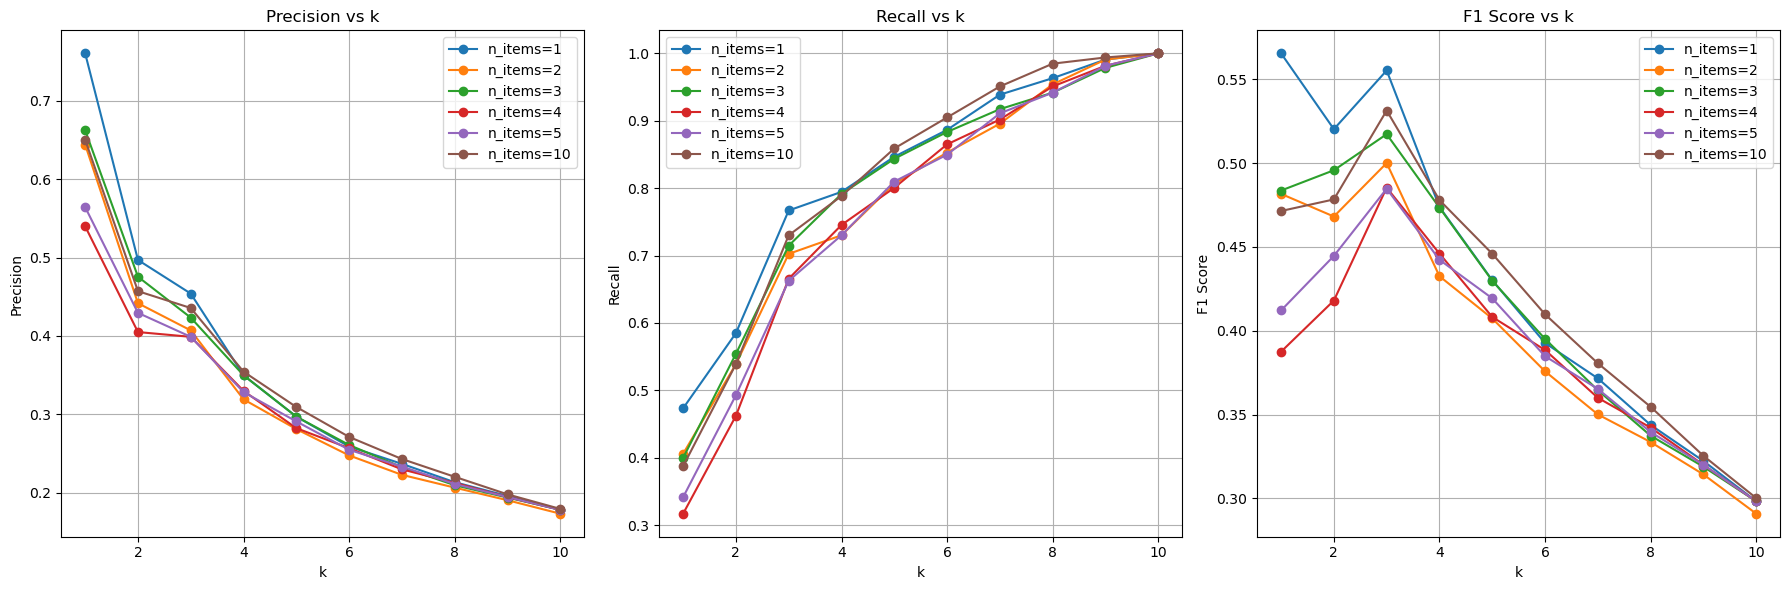

In [31]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet101_df)

# Fim do APAGAR???

In [32]:
def evaluate_xtimes_recommendation_system(ratings_df, similarity_df, ks=range(1, 11), num_runs=5, n_items=5):

    all_precisions, all_recalls, all_f1scores = run_multiple_evaluations(ratings_df, similarity_df, ks, num_runs, n_items)
    avg_precisions, avg_recalls, avg_f1scores = evaluate_multiple_metrics_avg(all_precisions, all_recalls, all_f1scores, ks)

    for k in ks:
        print(f"k={k}:", f"  Average Precision: {avg_precisions[k]:.4f}" , f"  Average Recall: {avg_recalls[k]:.4f}", f"  Average F1-score: {avg_f1scores[k]:.4f}")

In [33]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet101_df, n_items=5)

k=1:   Average Precision: 0.6012   Average Recall: 0.3507   Average F1-score: 0.4305
k=2:   Average Precision: 0.4202   Average Recall: 0.4806   Average F1-score: 0.4344
k=3:   Average Precision: 0.3906   Average Recall: 0.6472   Average F1-score: 0.4742
k=4:   Average Precision: 0.3344   Average Recall: 0.7485   Average F1-score: 0.4513
k=5:   Average Precision: 0.2883   Average Recall: 0.8129   Average F1-score: 0.4167
k=6:   Average Precision: 0.2587   Average Recall: 0.8712   Average F1-score: 0.3916
k=7:   Average Precision: 0.2314   Average Recall: 0.9049   Average F1-score: 0.3626
k=8:   Average Precision: 0.2094   Average Recall: 0.9417   Average F1-score: 0.3374
k=9:   Average Precision: 0.1943   Average Recall: 0.9877   Average F1-score: 0.3202
k=10:   Average Precision: 0.1773   Average Recall: 1.0000   Average F1-score: 0.2974


# 2. Aplication - Pixel-based

## VGG Model

### VGG16

#### Cosine Distance

In [34]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_vgg16_df)

k=1:   Average Precision: 0.4785   Average Recall: 0.2863   Average F1-score: 0.3466
k=2:   Average Precision: 0.3589   Average Recall: 0.4100   Average F1-score: 0.3699
k=3:   Average Precision: 0.3599   Average Recall: 0.6043   Average F1-score: 0.4380
k=4:   Average Precision: 0.3083   Average Recall: 0.6902   Average F1-score: 0.4157
k=5:   Average Precision: 0.2761   Average Recall: 0.7822   Average F1-score: 0.3991
k=6:   Average Precision: 0.2485   Average Recall: 0.8466   Average F1-score: 0.3767
k=7:   Average Precision: 0.2252   Average Recall: 0.8926   Average F1-score: 0.3535
k=8:   Average Precision: 0.2063   Average Recall: 0.9387   Average F1-score: 0.3329
k=9:   Average Precision: 0.1875   Average Recall: 0.9571   Average F1-score: 0.3090
k=10:   Average Precision: 0.1755   Average Recall: 1.0000   Average F1-score: 0.2946


In [35]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_vgg16_df)

k=1:  Average Precision: 0.5399  Average Recall: 0.3415  Average F1-score: 0.4039
k=2:  Average Precision: 0.3988  Average Recall: 0.4683  Average F1-score: 0.4160
k=3:  Average Precision: 0.3538  Average Recall: 0.6074  Average F1-score: 0.4331
k=4:  Average Precision: 0.3006  Average Recall: 0.6933  Average F1-score: 0.4079
k=5:  Average Precision: 0.2601  Average Recall: 0.7515  Average F1-score: 0.3772
k=6:  Average Precision: 0.2290  Average Recall: 0.8037  Average F1-score: 0.3487
k=7:  Average Precision: 0.2165  Average Recall: 0.8926  Average F1-score: 0.3416
k=8:  Average Precision: 0.1963  Average Recall: 0.9233  Average F1-score: 0.3181
k=9:  Average Precision: 0.1820  Average Recall: 0.9693  Average F1-score: 0.3015
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


#### Euclidean Distance

In [36]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_vgg16_df)

k=1:   Average Precision: 0.6564   Average Recall: 0.4243   Average F1-score: 0.4980
k=2:   Average Precision: 0.4724   Average Recall: 0.5787   Average F1-score: 0.5018
k=3:   Average Precision: 0.4335   Average Recall: 0.7638   Average F1-score: 0.5362
k=4:   Average Precision: 0.3482   Average Recall: 0.8129   Average F1-score: 0.4746
k=5:   Average Precision: 0.2957   Average Recall: 0.8620   Average F1-score: 0.4301
k=6:   Average Precision: 0.2556   Average Recall: 0.8957   Average F1-score: 0.3894
k=7:   Average Precision: 0.2261   Average Recall: 0.9233   Average F1-score: 0.3564
k=8:   Average Precision: 0.2048   Average Recall: 0.9601   Average F1-score: 0.3317
k=9:   Average Precision: 0.1868   Average Recall: 0.9816   Average F1-score: 0.3089
k=10:   Average Precision: 0.1706   Average Recall: 1.0000   Average F1-score: 0.2871


In [37]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_vgg16_df)

k=1:  Average Precision: 0.5399  Average Recall: 0.3262  Average F1-score: 0.3937
k=2:  Average Precision: 0.3896  Average Recall: 0.4499  Average F1-score: 0.4037
k=3:  Average Precision: 0.3824  Average Recall: 0.6534  Average F1-score: 0.4681
k=4:  Average Precision: 0.3160  Average Recall: 0.7209  Average F1-score: 0.4280
k=5:  Average Precision: 0.2687  Average Recall: 0.7822  Average F1-score: 0.3904
k=6:  Average Precision: 0.2372  Average Recall: 0.8313  Average F1-score: 0.3612
k=7:  Average Precision: 0.2121  Average Recall: 0.8742  Average F1-score: 0.3346
k=8:  Average Precision: 0.1963  Average Recall: 0.9264  Average F1-score: 0.3182
k=9:  Average Precision: 0.1806  Average Recall: 0.9632  Average F1-score: 0.2992
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### VGG19

#### Cosine Distance

In [38]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_vgg19_df)

k=1:   Average Precision: 0.5583   Average Recall: 0.3170   Average F1-score: 0.3937
k=2:   Average Precision: 0.4018   Average Recall: 0.4468   Average F1-score: 0.4108
k=3:   Average Precision: 0.3742   Average Recall: 0.6012   Average F1-score: 0.4503
k=4:   Average Precision: 0.3083   Average Recall: 0.6656   Average F1-score: 0.4124
k=5:   Average Precision: 0.2761   Average Recall: 0.7485   Average F1-score: 0.3959
k=6:   Average Precision: 0.2423   Average Recall: 0.8006   Average F1-score: 0.3655
k=7:   Average Precision: 0.2296   Average Recall: 0.8926   Average F1-score: 0.3595
k=8:   Average Precision: 0.2101   Average Recall: 0.9387   Average F1-score: 0.3384
k=9:   Average Precision: 0.1915   Average Recall: 0.9632   Average F1-score: 0.3153
k=10:   Average Precision: 0.1785   Average Recall: 1.0000   Average F1-score: 0.2992


In [39]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_vgg19_df)

k=1:  Average Precision: 0.4847  Average Recall: 0.2863  Average F1-score: 0.3487
k=2:  Average Precision: 0.3957  Average Recall: 0.4468  Average F1-score: 0.4067
k=3:  Average Precision: 0.3620  Average Recall: 0.5982  Average F1-score: 0.4387
k=4:  Average Precision: 0.2945  Average Recall: 0.6595  Average F1-score: 0.3969
k=5:  Average Precision: 0.2736  Average Recall: 0.7975  Average F1-score: 0.3977
k=6:  Average Precision: 0.2434  Average Recall: 0.8558  Average F1-score: 0.3708
k=7:  Average Precision: 0.2235  Average Recall: 0.9233  Average F1-score: 0.3529
k=8:  Average Precision: 0.2048  Average Recall: 0.9724  Average F1-score: 0.3322
k=9:  Average Precision: 0.1847  Average Recall: 0.9877  Average F1-score: 0.3061
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


#### Euclidean Distance

In [40]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_vgg19_df)

k=1:   Average Precision: 0.6196   Average Recall: 0.3691   Average F1-score: 0.4489
k=2:   Average Precision: 0.4417   Average Recall: 0.5143   Average F1-score: 0.4599
k=3:   Average Precision: 0.4192   Average Recall: 0.6994   Average F1-score: 0.5104
k=4:   Average Precision: 0.3405   Average Recall: 0.7607   Average F1-score: 0.4595
k=5:   Average Precision: 0.2896   Average Recall: 0.8067   Average F1-score: 0.4175
k=6:   Average Precision: 0.2587   Average Recall: 0.8650   Average F1-score: 0.3912
k=7:   Average Precision: 0.2358   Average Recall: 0.9264   Average F1-score: 0.3697
k=8:   Average Precision: 0.2124   Average Recall: 0.9509   Average F1-score: 0.3422
k=9:   Average Precision: 0.1943   Average Recall: 0.9816   Average F1-score: 0.3200
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983


In [41]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_vgg19_df)

k=1:  Average Precision: 0.6012  Average Recall: 0.3814  Average F1-score: 0.4509
k=2:  Average Precision: 0.4325  Average Recall: 0.5143  Average F1-score: 0.4538
k=3:  Average Precision: 0.3926  Average Recall: 0.6840  Average F1-score: 0.4834
k=4:  Average Precision: 0.3282  Average Recall: 0.7730  Average F1-score: 0.4480
k=5:  Average Precision: 0.2810  Average Recall: 0.8282  Average F1-score: 0.4094
k=6:  Average Precision: 0.2464  Average Recall: 0.8773  Average F1-score: 0.3763
k=7:  Average Precision: 0.2226  Average Recall: 0.9202  Average F1-score: 0.3515
k=8:  Average Precision: 0.2017  Average Recall: 0.9601  Average F1-score: 0.3273
k=9:  Average Precision: 0.1820  Average Recall: 0.9785  Average F1-score: 0.3018
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


## ResNet Model

### ResNet50 and ResNet50v2

#### Cosine Distance

In [42]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet50_df)

k=1:   Average Precision: 0.5828   Average Recall: 0.3415   Average F1-score: 0.4182
k=2:   Average Precision: 0.4264   Average Recall: 0.4806   Average F1-score: 0.4384
k=3:   Average Precision: 0.3824   Average Recall: 0.6288   Average F1-score: 0.4632
k=4:   Average Precision: 0.3221   Average Recall: 0.7147   Average F1-score: 0.4337
k=5:   Average Precision: 0.2810   Average Recall: 0.7791   Average F1-score: 0.4047
k=6:   Average Precision: 0.2556   Average Recall: 0.8466   Average F1-score: 0.3859
k=7:   Average Precision: 0.2331   Average Recall: 0.9049   Average F1-score: 0.3650
k=8:   Average Precision: 0.2109   Average Recall: 0.9356   Average F1-score: 0.3393
k=9:   Average Precision: 0.1929   Average Recall: 0.9755   Average F1-score: 0.3177
k=10:   Average Precision: 0.1785   Average Recall: 1.0000   Average F1-score: 0.2992


In [43]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet50_df)

k=1:  Average Precision: 0.4908  Average Recall: 0.2832  Average F1-score: 0.3487
k=2:  Average Precision: 0.3926  Average Recall: 0.4376  Average F1-score: 0.4016
k=3:  Average Precision: 0.3640  Average Recall: 0.5982  Average F1-score: 0.4405
k=4:  Average Precision: 0.3067  Average Recall: 0.6963  Average F1-score: 0.4149
k=5:  Average Precision: 0.2736  Average Recall: 0.7975  Average F1-score: 0.3977
k=6:  Average Precision: 0.2536  Average Recall: 0.8926  Average F1-score: 0.3866
k=7:  Average Precision: 0.2252  Average Recall: 0.9325  Average F1-score: 0.3558
k=8:  Average Precision: 0.2032  Average Recall: 0.9632  Average F1-score: 0.3297
k=9:  Average Precision: 0.1847  Average Recall: 0.9847  Average F1-score: 0.3060
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [44]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet50v2_df)

k=1:   Average Precision: 0.5890   Average Recall: 0.3538   Average F1-score: 0.4284
k=2:   Average Precision: 0.4172   Average Recall: 0.4744   Average F1-score: 0.4303
k=3:   Average Precision: 0.4049   Average Recall: 0.6779   Average F1-score: 0.4933
k=4:   Average Precision: 0.3359   Average Recall: 0.7546   Average F1-score: 0.4538
k=5:   Average Precision: 0.2822   Average Recall: 0.7914   Average F1-score: 0.4073
k=6:   Average Precision: 0.2566   Average Recall: 0.8620   Average F1-score: 0.3883
k=7:   Average Precision: 0.2323   Average Recall: 0.9110   Average F1-score: 0.3641
k=8:   Average Precision: 0.2101   Average Recall: 0.9417   Average F1-score: 0.3385
k=9:   Average Precision: 0.1936   Average Recall: 0.9755   Average F1-score: 0.3187
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983


In [45]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet50v2_df)

k=1:  Average Precision: 0.5460  Average Recall: 0.3354  Average F1-score: 0.4018
k=2:  Average Precision: 0.3865  Average Recall: 0.4714  Average F1-score: 0.4088
k=3:  Average Precision: 0.3763  Average Recall: 0.6595  Average F1-score: 0.4638
k=4:  Average Precision: 0.3113  Average Recall: 0.7301  Average F1-score: 0.4243
k=5:  Average Precision: 0.2712  Average Recall: 0.7914  Average F1-score: 0.3942
k=6:  Average Precision: 0.2423  Average Recall: 0.8589  Average F1-score: 0.3697
k=7:  Average Precision: 0.2200  Average Recall: 0.9110  Average F1-score: 0.3474
k=8:  Average Precision: 0.1979  Average Recall: 0.9387  Average F1-score: 0.3209
k=9:  Average Precision: 0.1813  Average Recall: 0.9693  Average F1-score: 0.3004
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


#### Euclidean Distance

In [46]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet50_df)

k=1:   Average Precision: 0.5276   Average Recall: 0.2955   Average F1-score: 0.3691
k=2:   Average Precision: 0.4325   Average Recall: 0.4806   Average F1-score: 0.4425
k=3:   Average Precision: 0.3845   Average Recall: 0.6227   Average F1-score: 0.4638
k=4:   Average Precision: 0.3313   Average Recall: 0.7147   Average F1-score: 0.4435
k=5:   Average Precision: 0.2847   Average Recall: 0.7761   Average F1-score: 0.4088
k=6:   Average Precision: 0.2566   Average Recall: 0.8466   Average F1-score: 0.3872
k=7:   Average Precision: 0.2340   Average Recall: 0.9049   Average F1-score: 0.3662
k=8:   Average Precision: 0.2155   Average Recall: 0.9479   Average F1-score: 0.3464
k=9:   Average Precision: 0.1963   Average Recall: 0.9724   Average F1-score: 0.3226
k=10:   Average Precision: 0.1816   Average Recall: 1.0000   Average F1-score: 0.3039


In [47]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet50_df)

k=1:  Average Precision: 0.4969  Average Recall: 0.2955  Average F1-score: 0.3589
k=2:  Average Precision: 0.3804  Average Recall: 0.4376  Average F1-score: 0.3935
k=3:  Average Precision: 0.3538  Average Recall: 0.5951  Average F1-score: 0.4307
k=4:  Average Precision: 0.3021  Average Recall: 0.6963  Average F1-score: 0.4100
k=5:  Average Precision: 0.2724  Average Recall: 0.7853  Average F1-score: 0.3950
k=6:  Average Precision: 0.2393  Average Recall: 0.8344  Average F1-score: 0.3640
k=7:  Average Precision: 0.2147  Average Recall: 0.8773  Average F1-score: 0.3384
k=8:  Average Precision: 0.1963  Average Recall: 0.9294  Average F1-score: 0.3183
k=9:  Average Precision: 0.1827  Average Recall: 0.9785  Average F1-score: 0.3028
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [48]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet50v2_df)

k=1:   Average Precision: 0.6258   Average Recall: 0.3538   Average F1-score: 0.4407
k=2:   Average Precision: 0.4233   Average Recall: 0.4591   Average F1-score: 0.4292
k=3:   Average Precision: 0.3988   Average Recall: 0.6350   Average F1-score: 0.4791
k=4:   Average Precision: 0.3313   Average Recall: 0.7025   Average F1-score: 0.4419
k=5:   Average Precision: 0.2859   Average Recall: 0.7638   Average F1-score: 0.4091
k=6:   Average Precision: 0.2597   Average Recall: 0.8436   Average F1-score: 0.3910
k=7:   Average Precision: 0.2393   Average Recall: 0.9049   Average F1-score: 0.3733
k=8:   Average Precision: 0.2216   Average Recall: 0.9601   Average F1-score: 0.3557
k=9:   Average Precision: 0.2031   Average Recall: 0.9908   Average F1-score: 0.3334
k=10:   Average Precision: 0.1840   Average Recall: 1.0000   Average F1-score: 0.3076


In [49]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet50v2_df)

k=1:  Average Precision: 0.5706  Average Recall: 0.3569  Average F1-score: 0.4243
k=2:  Average Precision: 0.4049  Average Recall: 0.4898  Average F1-score: 0.4272
k=3:  Average Precision: 0.3620  Average Recall: 0.6380  Average F1-score: 0.4466
k=4:  Average Precision: 0.3006  Average Recall: 0.7086  Average F1-score: 0.4100
k=5:  Average Precision: 0.2589  Average Recall: 0.7638  Average F1-score: 0.3769
k=6:  Average Precision: 0.2413  Average Recall: 0.8650  Average F1-score: 0.3688
k=7:  Average Precision: 0.2209  Average Recall: 0.9202  Average F1-score: 0.3491
k=8:  Average Precision: 0.2040  Average Recall: 0.9755  Average F1-score: 0.3313
k=9:  Average Precision: 0.1854  Average Recall: 0.9939  Average F1-score: 0.3074
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### ResNet101 and ResNet101v2

#### Cosine Distance

In [50]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet101_df)

k=1:   Average Precision: 0.4294   Average Recall: 0.2219   Average F1-score: 0.2873
k=2:   Average Precision: 0.3681   Average Recall: 0.3701   Average F1-score: 0.3628
k=3:   Average Precision: 0.3620   Average Recall: 0.5583   Average F1-score: 0.4307
k=4:   Average Precision: 0.3236   Average Recall: 0.6810   Average F1-score: 0.4309
k=5:   Average Precision: 0.2908   Average Recall: 0.7791   Average F1-score: 0.4164
k=6:   Average Precision: 0.2587   Average Recall: 0.8436   Average F1-score: 0.3896
k=7:   Average Precision: 0.2331   Average Recall: 0.8957   Average F1-score: 0.3645
k=8:   Average Precision: 0.2140   Average Recall: 0.9356   Average F1-score: 0.3437
k=9:   Average Precision: 0.1997   Average Recall: 0.9816   Average F1-score: 0.3280
k=10:   Average Precision: 0.1828   Average Recall: 1.0000   Average F1-score: 0.3057


In [51]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet101_df)

k=1:  Average Precision: 0.4724  Average Recall: 0.2802  Average F1-score: 0.3405
k=2:  Average Precision: 0.3681  Average Recall: 0.4131  Average F1-score: 0.3771
k=3:  Average Precision: 0.3579  Average Recall: 0.6043  Average F1-score: 0.4362
k=4:  Average Precision: 0.3021  Average Recall: 0.6963  Average F1-score: 0.4100
k=5:  Average Precision: 0.2675  Average Recall: 0.7822  Average F1-score: 0.3889
k=6:  Average Precision: 0.2423  Average Recall: 0.8558  Average F1-score: 0.3695
k=7:  Average Precision: 0.2182  Average Recall: 0.9018  Average F1-score: 0.3445
k=8:  Average Precision: 0.2009  Average Recall: 0.9571  Average F1-score: 0.3261
k=9:  Average Precision: 0.1827  Average Recall: 0.9785  Average F1-score: 0.3028
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [52]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet101v2_df)

k=1:   Average Precision: 0.5706   Average Recall: 0.3384   Average F1-score: 0.4121
k=2:   Average Precision: 0.4141   Average Recall: 0.4775   Average F1-score: 0.4292
k=3:   Average Precision: 0.3783   Average Recall: 0.6319   Average F1-score: 0.4601
k=4:   Average Precision: 0.3221   Average Recall: 0.7270   Average F1-score: 0.4353
k=5:   Average Precision: 0.2785   Average Recall: 0.7822   Average F1-score: 0.4021
k=6:   Average Precision: 0.2505   Average Recall: 0.8436   Average F1-score: 0.3791
k=7:   Average Precision: 0.2252   Average Recall: 0.8834   Average F1-score: 0.3530
k=8:   Average Precision: 0.2071   Average Recall: 0.9294   Average F1-score: 0.3336
k=9:   Average Precision: 0.1909   Average Recall: 0.9632   Average F1-score: 0.3143
k=10:   Average Precision: 0.1785   Average Recall: 1.0000   Average F1-score: 0.2992


In [53]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet101v2_df)

k=1:  Average Precision: 0.5215  Average Recall: 0.3292  Average F1-score: 0.3896
k=2:  Average Precision: 0.3804  Average Recall: 0.4591  Average F1-score: 0.4006
k=3:  Average Precision: 0.3558  Average Recall: 0.6135  Average F1-score: 0.4362
k=4:  Average Precision: 0.3144  Average Recall: 0.7331  Average F1-score: 0.4280
k=5:  Average Precision: 0.2822  Average Recall: 0.8282  Average F1-score: 0.4108
k=6:  Average Precision: 0.2485  Average Recall: 0.8834  Average F1-score: 0.3793
k=7:  Average Precision: 0.2182  Average Recall: 0.9049  Average F1-score: 0.3447
k=8:  Average Precision: 0.2017  Average Recall: 0.9601  Average F1-score: 0.3273
k=9:  Average Precision: 0.1847  Average Recall: 0.9908  Average F1-score: 0.3062
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


#### Euclidean Distance

In [54]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet101_df)

k=1:   Average Precision: 0.5828   Average Recall: 0.3507   Average F1-score: 0.4243
k=2:   Average Precision: 0.4387   Average Recall: 0.5174   Average F1-score: 0.4589
k=3:   Average Precision: 0.4029   Average Recall: 0.6810   Average F1-score: 0.4920
k=4:   Average Precision: 0.3313   Average Recall: 0.7454   Average F1-score: 0.4476
k=5:   Average Precision: 0.2883   Average Recall: 0.8067   Average F1-score: 0.4161
k=6:   Average Precision: 0.2577   Average Recall: 0.8620   Average F1-score: 0.3896
k=7:   Average Precision: 0.2296   Average Recall: 0.8957   Average F1-score: 0.3597
k=8:   Average Precision: 0.2055   Average Recall: 0.9202   Average F1-score: 0.3310
k=9:   Average Precision: 0.1915   Average Recall: 0.9693   Average F1-score: 0.3155
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983


In [55]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet101_df)

k=1:  Average Precision: 0.5644  Average Recall: 0.3446  Average F1-score: 0.4141
k=2:  Average Precision: 0.3896  Average Recall: 0.4468  Average F1-score: 0.4027
k=3:  Average Precision: 0.3558  Average Recall: 0.6012  Average F1-score: 0.4337
k=4:  Average Precision: 0.3021  Average Recall: 0.6963  Average F1-score: 0.4100
k=5:  Average Precision: 0.2601  Average Recall: 0.7515  Average F1-score: 0.3772
k=6:  Average Precision: 0.2321  Average Recall: 0.8098  Average F1-score: 0.3531
k=7:  Average Precision: 0.2130  Average Recall: 0.8773  Average F1-score: 0.3360
k=8:  Average Precision: 0.1971  Average Recall: 0.9325  Average F1-score: 0.3196
k=9:  Average Precision: 0.1813  Average Recall: 0.9693  Average F1-score: 0.3004
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [56]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet101v2_df)

k=1:   Average Precision: 0.6012   Average Recall: 0.3507   Average F1-score: 0.4305
k=2:   Average Precision: 0.4172   Average Recall: 0.4806   Average F1-score: 0.4323
k=3:   Average Precision: 0.3701   Average Recall: 0.6135   Average F1-score: 0.4491
k=4:   Average Precision: 0.3144   Average Recall: 0.7117   Average F1-score: 0.4251
k=5:   Average Precision: 0.2712   Average Recall: 0.7669   Average F1-score: 0.3918
k=6:   Average Precision: 0.2485   Average Recall: 0.8466   Average F1-score: 0.3767
k=7:   Average Precision: 0.2244   Average Recall: 0.8896   Average F1-score: 0.3522
k=8:   Average Precision: 0.2078   Average Recall: 0.9448   Average F1-score: 0.3354
k=9:   Average Precision: 0.1909   Average Recall: 0.9847   Average F1-score: 0.3151
k=10:   Average Precision: 0.1736   Average Recall: 1.0000   Average F1-score: 0.2918


In [57]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet101v2_df)

k=1:  Average Precision: 0.5153  Average Recall: 0.3292  Average F1-score: 0.3875
k=2:  Average Precision: 0.3650  Average Recall: 0.4315  Average F1-score: 0.3812
k=3:  Average Precision: 0.3190  Average Recall: 0.5460  Average F1-score: 0.3896
k=4:  Average Precision: 0.2623  Average Recall: 0.6074  Average F1-score: 0.3556
k=5:  Average Precision: 0.2356  Average Recall: 0.6871  Average F1-score: 0.3419
k=6:  Average Precision: 0.2178  Average Recall: 0.7730  Average F1-score: 0.3320
k=7:  Average Precision: 0.2016  Average Recall: 0.8405  Average F1-score: 0.3184
k=8:  Average Precision: 0.1917  Average Recall: 0.9110  Average F1-score: 0.3110
k=9:  Average Precision: 0.1786  Average Recall: 0.9540  Average F1-score: 0.2959
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### ResNet152 and ResNet152v2

#### Cosine Distance

In [58]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet152_df)

k=1:   Average Precision: 0.5399   Average Recall: 0.3139   Average F1-score: 0.3855
k=2:   Average Precision: 0.4110   Average Recall: 0.4744   Average F1-score: 0.4262
k=3:   Average Precision: 0.3804   Average Recall: 0.6288   Average F1-score: 0.4613
k=4:   Average Precision: 0.3190   Average Recall: 0.6963   Average F1-score: 0.4280
k=5:   Average Precision: 0.2822   Average Recall: 0.7791   Average F1-score: 0.4061
k=6:   Average Precision: 0.2577   Average Recall: 0.8558   Average F1-score: 0.3892
k=7:   Average Precision: 0.2305   Average Recall: 0.8926   Average F1-score: 0.3607
k=8:   Average Precision: 0.2109   Average Recall: 0.9294   Average F1-score: 0.3391
k=9:   Average Precision: 0.1936   Average Recall: 0.9663   Average F1-score: 0.3184
k=10:   Average Precision: 0.1804   Average Recall: 1.0000   Average F1-score: 0.3020


In [59]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet152_df)

k=1:  Average Precision: 0.4969  Average Recall: 0.2924  Average F1-score: 0.3569
k=2:  Average Precision: 0.4172  Average Recall: 0.4928  Average F1-score: 0.4364
k=3:  Average Precision: 0.3742  Average Recall: 0.6380  Average F1-score: 0.4577
k=4:  Average Precision: 0.3037  Average Recall: 0.6933  Average F1-score: 0.4112
k=5:  Average Precision: 0.2663  Average Recall: 0.7730  Average F1-score: 0.3866
k=6:  Average Precision: 0.2413  Average Recall: 0.8528  Average F1-score: 0.3680
k=7:  Average Precision: 0.2138  Average Recall: 0.8865  Average F1-score: 0.3377
k=8:  Average Precision: 0.1986  Average Recall: 0.9417  Average F1-score: 0.3222
k=9:  Average Precision: 0.1854  Average Recall: 0.9908  Average F1-score: 0.3073
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [60]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_sim_resnet152v2_df)

k=1:   Average Precision: 0.4847   Average Recall: 0.3047   Average F1-score: 0.3609
k=2:   Average Precision: 0.3681   Average Recall: 0.4468   Average F1-score: 0.3883
k=3:   Average Precision: 0.3415   Average Recall: 0.6012   Average F1-score: 0.4209
k=4:   Average Precision: 0.2929   Average Recall: 0.6810   Average F1-score: 0.3981
k=5:   Average Precision: 0.2613   Average Recall: 0.7699   Average F1-score: 0.3804
k=6:   Average Precision: 0.2393   Average Recall: 0.8436   Average F1-score: 0.3647
k=7:   Average Precision: 0.2200   Average Recall: 0.9018   Average F1-score: 0.3469
k=8:   Average Precision: 0.2048   Average Recall: 0.9571   Average F1-score: 0.3316
k=9:   Average Precision: 0.1868   Average Recall: 0.9816   Average F1-score: 0.3089
k=10:   Average Precision: 0.1712   Average Recall: 1.0000   Average F1-score: 0.2881


In [61]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_sim_resnet152v2_df)

k=1:  Average Precision: 0.4601  Average Recall: 0.2894  Average F1-score: 0.3425
k=2:  Average Precision: 0.3681  Average Recall: 0.4438  Average F1-score: 0.3873
k=3:  Average Precision: 0.3579  Average Recall: 0.6258  Average F1-score: 0.4405
k=4:  Average Precision: 0.2945  Average Recall: 0.6871  Average F1-score: 0.4006
k=5:  Average Precision: 0.2552  Average Recall: 0.7423  Average F1-score: 0.3705
k=6:  Average Precision: 0.2311  Average Recall: 0.8129  Average F1-score: 0.3520
k=7:  Average Precision: 0.2112  Average Recall: 0.8681  Average F1-score: 0.3331
k=8:  Average Precision: 0.1963  Average Recall: 0.9294  Average F1-score: 0.3183
k=9:  Average Precision: 0.1820  Average Recall: 0.9724  Average F1-score: 0.3016
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


#### Euclidean Distance

In [62]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet152_df)

k=1:   Average Precision: 0.5644   Average Recall: 0.3354   Average F1-score: 0.4080
k=2:   Average Precision: 0.4018   Average Recall: 0.4652   Average F1-score: 0.4170
k=3:   Average Precision: 0.3763   Average Recall: 0.6258   Average F1-score: 0.4571
k=4:   Average Precision: 0.3067   Average Recall: 0.6840   Average F1-score: 0.4133
k=5:   Average Precision: 0.2675   Average Recall: 0.7423   Average F1-score: 0.3851
k=6:   Average Precision: 0.2464   Average Recall: 0.8313   Average F1-score: 0.3730
k=7:   Average Precision: 0.2261   Average Recall: 0.9018   Average F1-score: 0.3552
k=8:   Average Precision: 0.2040   Average Recall: 0.9387   Average F1-score: 0.3297
k=9:   Average Precision: 0.1868   Average Recall: 0.9693   Average F1-score: 0.3085
k=10:   Average Precision: 0.1730   Average Recall: 1.0000   Average F1-score: 0.2909


In [63]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet152_df)

k=1:  Average Precision: 0.5828  Average Recall: 0.3599  Average F1-score: 0.4305
k=2:  Average Precision: 0.4294  Average Recall: 0.4990  Average F1-score: 0.4466
k=3:  Average Precision: 0.3824  Average Recall: 0.6534  Average F1-score: 0.4681
k=4:  Average Precision: 0.3221  Average Recall: 0.7393  Average F1-score: 0.4370
k=5:  Average Precision: 0.2785  Average Recall: 0.8006  Average F1-score: 0.4038
k=6:  Average Precision: 0.2464  Average Recall: 0.8620  Average F1-score: 0.3752
k=7:  Average Precision: 0.2200  Average Recall: 0.9080  Average F1-score: 0.3472
k=8:  Average Precision: 0.1994  Average Recall: 0.9509  Average F1-score: 0.3237
k=9:  Average Precision: 0.1820  Average Recall: 0.9724  Average F1-score: 0.3016
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


In [64]:
evaluate_xtimes_recommendation_system(ratings_df, pixel_eu_sim_resnet152v2_df)

k=1:   Average Precision: 0.5890   Average Recall: 0.3476   Average F1-score: 0.4243
k=2:   Average Precision: 0.4387   Average Recall: 0.5082   Average F1-score: 0.4558
k=3:   Average Precision: 0.4049   Average Recall: 0.6779   Average F1-score: 0.4933
k=4:   Average Precision: 0.3420   Average Recall: 0.7699   Average F1-score: 0.4623
k=5:   Average Precision: 0.2945   Average Recall: 0.8252   Average F1-score: 0.4251
k=6:   Average Precision: 0.2628   Average Recall: 0.8896   Average F1-score: 0.3982
k=7:   Average Precision: 0.2410   Average Recall: 0.9509   Average F1-score: 0.3783
k=8:   Average Precision: 0.2170   Average Recall: 0.9785   Average F1-score: 0.3500
k=9:   Average Precision: 0.1956   Average Recall: 0.9908   Average F1-score: 0.3223
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983


In [65]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, pixel_eu_sim_resnet152v2_df)

k=1:  Average Precision: 0.5337  Average Recall: 0.3476  Average F1-score: 0.4059
k=2:  Average Precision: 0.3865  Average Recall: 0.4683  Average F1-score: 0.4078
k=3:  Average Precision: 0.3374  Average Recall: 0.5828  Average F1-score: 0.4135
k=4:  Average Precision: 0.2791  Average Recall: 0.6472  Average F1-score: 0.3789
k=5:  Average Precision: 0.2429  Average Recall: 0.7055  Average F1-score: 0.3524
k=6:  Average Precision: 0.2178  Average Recall: 0.7607  Average F1-score: 0.3311
k=7:  Average Precision: 0.2138  Average Recall: 0.8834  Average F1-score: 0.3375
k=8:  Average Precision: 0.1956  Average Recall: 0.9264  Average F1-score: 0.3171
k=9:  Average Precision: 0.1854  Average Recall: 0.9939  Average F1-score: 0.3074
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


# Pre-processing Emotion-based

In [66]:
# From the photos_df select only the ones that have views
photos_w_ids_df = photos_df[photos_df['views'] > 0]
photos_ids_views = photos_w_ids_df['id'].unique()
print(len(photos_df))
print(len(photos_ids_views))

filtered_ratings_df = ratings_df[ratings_df['id_photo'].isin(photos_ids_views)]
filtered_ratings_df

2885
553


,id,id_photo,id_survey,like_bool,anger,fear,disgust,sadness,happiness,surprise,neutral,valence,arousal,dominance
0,1,1754,1,1,0,0,0,0,0,0,5,3,1,2
1,2,1785,1,1,0,0,0,2,0,0,0,2,2,3
2,3,123,1,0,0,0,0,4,0,0,0,1,3,1
3,4,2315,1,0,0,0,0,2,0,0,0,2,1,3
4,5,1548,1,0,0,0,0,0,0,0,5,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2441,2546,163,0,0,5,0,5,0,0,0,1,5,1
2441,2442,2097,163,0,0,0,3,0,5,0,0,2,2,1
2442,2443,1898,163,0,0,0,3,5,0,1,0,1,4,1
2443,2444,1871,163,0,0,0,0,5,0,0,0,1,1,1


In [67]:
emotions_columns = ['anger', 'fear', 'disgust', 'sadness', 'happiness', 'surprise', 'neutral', 'valence', 'arousal', 'dominance']
# group the emotions and get the mean
mean_emotions_per_photo_df = filtered_ratings_df.groupby('id_photo')[emotions_columns].mean().reset_index()

mean_emotions_per_photo_df

,id_photo,anger,fear,disgust,sadness,happiness,surprise,neutral,valence,arousal,dominance
0,2,0.0,3.090909,1.090909,0.0,0.363636,1.090909,0.0,2.454545,3.272727,2.727273
1,6,0.0,2.400000,0.000000,0.0,0.000000,1.600000,0.0,3.200000,3.000000,2.800000
2,14,0.0,2.800000,0.600000,0.0,0.000000,0.000000,0.0,2.200000,3.000000,2.800000
3,25,0.0,1.000000,0.000000,0.8,0.000000,0.000000,0.4,1.600000,2.200000,2.200000
4,32,0.0,0.000000,0.000000,0.0,4.666667,0.000000,0.0,5.000000,3.333333,2.666667
...,...,...,...,...,...,...,...,...,...,...,...
548,3054,0.0,0.000000,0.000000,1.8,2.000000,0.800000,0.0,4.000000,3.000000,3.600000
549,3057,0.0,0.400000,0.000000,2.8,0.000000,0.000000,0.0,2.400000,1.600000,2.400000
550,3059,0.0,0.000000,0.000000,2.8,0.000000,0.000000,0.6,2.600000,2.000000,2.600000
551,3062,0.0,0.000000,0.000000,3.0,0.000000,0.000000,0.0,1.000000,1.000000,2.000000


In [68]:
emotion_dic = {
    'emotions_dim': ['valence', 'arousal', 'dominance'],
    'emotions_cat': ['anger', 'fear', 'disgust', 'sadness', 'happiness', 'surprise', 'neutral']
}

# Global variables for the dataframes
emotions_dim_df = None
emotions_cat_df = None

for emotion_group, columns in emotion_dic.items():
    mean_emotions_per_photo_df['emotion_string'] = mean_emotions_per_photo_df[columns].astype(str).agg(','.join, axis=1)
    mean_emotions_per_photo_df['emotion_array'] = mean_emotions_per_photo_df['emotion_string'].apply(lambda x: np.fromstring(x, sep=','))
    mean_emotions_per_photo_df = mean_emotions_per_photo_df.drop(columns=['emotion_string'])

    emotions_array_df = mean_emotions_per_photo_df[['id_photo', 'emotion_array']]
    globals()[f'{emotion_group}_df'] = emotions_array_df

In [69]:
emotions_dim_df

,id_photo,emotion_array
0,2,"[2.4545454545454546, 3.272727272727273, 2.7272..."
1,6,"[3.2, 3.0, 2.8]"
2,14,"[2.2, 3.0, 2.8]"
3,25,"[1.6, 2.2, 2.2]"
4,32,"[5.0, 3.3333333333333335, 2.6666666666666665]"
...,...,...
548,3054,"[4.0, 3.0, 3.6]"
549,3057,"[2.4, 1.6, 2.4]"
550,3059,"[2.6, 2.0, 2.6]"
551,3062,"[1.0, 1.0, 2.0]"


# Emotions Extra Fuctions

In [70]:
def mean_emotion_arrays(arrays):
    """Calclates the mean emotion arrays along the specified axis.

    Args:
        arrays (list or np.ndarray): A list or NumPy arrray of emotion arrays, where each inner array contains emotion values.

    Returns:
        np.ndaaray: A NumPy array containing the mean values of the emotion arrays,
        calculated along the first axis, for each emorion across all arrays.
    """
    arrays = np.array(arrays)
    return np.mean(arrays, axis=0).tolist()

def extract_upper_triangular(matrix_df):
    """Extracts the upper triangular part of a similarity matrix and converts it into a DataFrame.

    Args:
        matrix_df (pd.DataFrame): A dataframe representing a similçarity matrix, were the rows and columns are indexed by photo ids.

    Returns:
        pd.DataFrame: a dataframe containing three columns: 'id_target', id_comparison' and 'similarity_score'.
        Each row represents a pair of photo ids with their similarity score.
    """
    photo_ids = matrix_df.index
    upper_triangular_data = []

    for i in range(len(photo_ids)):
        for j in range(i, len(photo_ids)):
            upper_triangular_data.append({
                'id_target': photo_ids[i],
                'id_comparison': photo_ids[j],
                'similarity_score': matrix_df.iloc[i, j]
            })

    upper_triangular_df = pd.DataFrame(upper_triangular_data)

    return upper_triangular_df

def get_emotion_similarity_score(emotion_df, distance):
    """Calculates the similarity scores between different emotions of different photos based on a distance metric.

    Args:
        emotion_df (pd.DataFrame): A DataFrame containig emotion data, with at least two columns:
        'id_photo' and 'emotion_array'. Each row corresponds to a photo and it's associated array of emotion values.
        distance (str): Distance metric to use for calculating similarities. Options are 'cosine' and 'euclidean'

    Raises:
        ValueError: If an invalid distance metric is provided. (the metrics available are 'cosine' and 'euclidean')

    Returns:
        pd.Dataframe: a dataframe containig the similarity scores between the photo ids. It contains the columns 'id_photo', 'id_comparison' and 'similarity_score'. 
    """
    emotion_mean_df = emotion_df.groupby('id_photo')['emotion_array'].apply(mean_emotion_arrays).reset_index()
    emotion_arrays_list = emotion_mean_df['emotion_array'].tolist()

    if distance == 'cosine':
        similarities_matrix = cosine_similarity(emotion_arrays_list)

    elif distance == 'euclidean':
        distances_matrix = euclidean_distances(emotion_arrays_list)

        max_value = np.max(distances_matrix)
        min_value = np.min(distances_matrix)
        similarities_matrix = 1 - (distances_matrix - min_value) / (max_value - min_value)

    else:
        raise ValueError("Invalid distance metric. Use 'cosine' or 'euclidean'.")

    similarities_df = pd.DataFrame(similarities_matrix, index=emotion_mean_df['id_photo'], columns=emotion_mean_df['id_photo'])
    upper_triangular_df = extract_upper_triangular(similarities_df)

    return upper_triangular_df

In [71]:
#Dimensional Emotions
cos_dim_sim_score_df = get_emotion_similarity_score(emotions_dim_df, 'cosine')
eu_dim_sim_score_df = get_emotion_similarity_score(emotions_dim_df, 'euclidean')

#Categorical Emotions
cos_cat_sim_score_df = get_emotion_similarity_score(emotions_cat_df, 'cosine')
eu_cat_sim_score_df = get_emotion_similarity_score(emotions_cat_df, 'euclidean')

# 3. Aplication - Emotion-based

## Categorical Emotions

### Cosine Distance

In [90]:
evaluate_xtimes_recommendation_system(ratings_df, cos_cat_sim_score_df)

k=1:   Average Precision: 0.6810   Average Recall: 0.3967   Average F1-score: 0.4877
k=2:   Average Precision: 0.4847   Average Recall: 0.5297   Average F1-score: 0.4937
k=3:   Average Precision: 0.4070   Average Recall: 0.6595   Average F1-score: 0.4914
k=4:   Average Precision: 0.3374   Average Recall: 0.7423   Average F1-score: 0.4538
k=5:   Average Precision: 0.2933   Average Recall: 0.8129   Average F1-score: 0.4225
k=6:   Average Precision: 0.2607   Average Recall: 0.8712   Average F1-score: 0.3942
k=7:   Average Precision: 0.2393   Average Recall: 0.9325   Average F1-score: 0.3748
k=8:   Average Precision: 0.2186   Average Recall: 0.9693   Average F1-score: 0.3517
k=9:   Average Precision: 0.1990   Average Recall: 0.9939   Average F1-score: 0.3274
k=10:   Average Precision: 0.1804   Average Recall: 1.0000   Average F1-score: 0.3020


In [91]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, cos_cat_sim_score_df)

k=1:  Average Precision: 0.6933  Average Recall: 0.4397  Average F1-score: 0.5204
k=2:  Average Precision: 0.4877  Average Recall: 0.5787  Average F1-score: 0.5121
k=3:  Average Precision: 0.4070  Average Recall: 0.7117  Average F1-score: 0.5018
k=4:  Average Precision: 0.3313  Average Recall: 0.7853  Average F1-score: 0.4529
k=5:  Average Precision: 0.2798  Average Recall: 0.8252  Average F1-score: 0.4076
k=6:  Average Precision: 0.2515  Average Recall: 0.8988  Average F1-score: 0.3844
k=7:  Average Precision: 0.2244  Average Recall: 0.9356  Average F1-score: 0.3547
k=8:  Average Precision: 0.2040  Average Recall: 0.9663  Average F1-score: 0.3309
k=9:  Average Precision: 0.1847  Average Recall: 0.9847  Average F1-score: 0.3060
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### Euclidean Distance

In [92]:
evaluate_xtimes_recommendation_system(ratings_df, eu_cat_sim_score_df)

k=1:   Average Precision: 0.6871   Average Recall: 0.4305   Average F1-score: 0.5123
k=2:   Average Precision: 0.5000   Average Recall: 0.5941   Average F1-score: 0.5254
k=3:   Average Precision: 0.4274   Average Recall: 0.7331   Average F1-score: 0.5245
k=4:   Average Precision: 0.3604   Average Recall: 0.8282   Average F1-score: 0.4897
k=5:   Average Precision: 0.3018   Average Recall: 0.8681   Average F1-score: 0.4380
k=6:   Average Precision: 0.2638   Average Recall: 0.9110   Average F1-score: 0.4010
k=7:   Average Precision: 0.2358   Average Recall: 0.9448   Average F1-score: 0.3708
k=8:   Average Precision: 0.2147   Average Recall: 0.9785   Average F1-score: 0.3467
k=9:   Average Precision: 0.1936   Average Recall: 0.9908   Average F1-score: 0.3193
k=10:   Average Precision: 0.1761   Average Recall: 1.0000   Average F1-score: 0.2955


In [93]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, eu_cat_sim_score_df)

k=1:  Average Precision: 0.6687  Average Recall: 0.4335  Average F1-score: 0.5082
k=2:  Average Precision: 0.4755  Average Recall: 0.5787  Average F1-score: 0.5039
k=3:  Average Precision: 0.4029  Average Recall: 0.7117  Average F1-score: 0.4982
k=4:  Average Precision: 0.3313  Average Recall: 0.7853  Average F1-score: 0.4529
k=5:  Average Precision: 0.2822  Average Recall: 0.8405  Average F1-score: 0.4120
k=6:  Average Precision: 0.2556  Average Recall: 0.9141  Average F1-score: 0.3907
k=7:  Average Precision: 0.2261  Average Recall: 0.9417  Average F1-score: 0.3575
k=8:  Average Precision: 0.2055  Average Recall: 0.9785  Average F1-score: 0.3336
k=9:  Average Precision: 0.1861  Average Recall: 0.9969  Average F1-score: 0.3085
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


## Dimensional Emotions

### Cosine Distance

In [94]:
evaluate_xtimes_recommendation_system(ratings_df, cos_dim_sim_score_df)

k=1:   Average Precision: 0.5828   Average Recall: 0.3292   Average F1-score: 0.4100
k=2:   Average Precision: 0.4785   Average Recall: 0.5297   Average F1-score: 0.4896
k=3:   Average Precision: 0.4151   Average Recall: 0.6748   Average F1-score: 0.5018
k=4:   Average Precision: 0.3405   Average Recall: 0.7454   Average F1-score: 0.4574
k=5:   Average Precision: 0.2994   Average Recall: 0.8221   Average F1-score: 0.4307
k=6:   Average Precision: 0.2669   Average Recall: 0.8773   Average F1-score: 0.4026
k=7:   Average Precision: 0.2410   Average Recall: 0.9233   Average F1-score: 0.3767
k=8:   Average Precision: 0.2186   Average Recall: 0.9571   Average F1-score: 0.3512
k=9:   Average Precision: 0.1984   Average Recall: 0.9755   Average F1-score: 0.3258
k=10:   Average Precision: 0.1822   Average Recall: 1.0000   Average F1-score: 0.3048


In [95]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, cos_dim_sim_score_df)

k=1:  Average Precision: 0.6012  Average Recall: 0.3691  Average F1-score: 0.4427
k=2:  Average Precision: 0.4632  Average Recall: 0.5542  Average F1-score: 0.4875
k=3:  Average Precision: 0.4070  Average Recall: 0.7086  Average F1-score: 0.5012
k=4:  Average Precision: 0.3252  Average Recall: 0.7669  Average F1-score: 0.4439
k=5:  Average Precision: 0.2810  Average Recall: 0.8282  Average F1-score: 0.4094
k=6:  Average Precision: 0.2526  Average Recall: 0.8988  Average F1-score: 0.3857
k=7:  Average Precision: 0.2270  Average Recall: 0.9417  Average F1-score: 0.3587
k=8:  Average Precision: 0.2048  Average Recall: 0.9755  Average F1-score: 0.3324
k=9:  Average Precision: 0.1847  Average Recall: 0.9908  Average F1-score: 0.3062
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### Euclidean Distance

In [96]:
evaluate_xtimes_recommendation_system(ratings_df, eu_dim_sim_score_df)

k=1:   Average Precision: 0.6442   Average Recall: 0.4029   Average F1-score: 0.4796
k=2:   Average Precision: 0.4663   Average Recall: 0.5542   Average F1-score: 0.4896
k=3:   Average Precision: 0.4110   Average Recall: 0.7055   Average F1-score: 0.5043
k=4:   Average Precision: 0.3390   Average Recall: 0.7822   Average F1-score: 0.4607
k=5:   Average Precision: 0.2883   Average Recall: 0.8344   Average F1-score: 0.4187
k=6:   Average Precision: 0.2577   Average Recall: 0.9018   Average F1-score: 0.3925
k=7:   Average Precision: 0.2305   Average Recall: 0.9387   Average F1-score: 0.3633
k=8:   Average Precision: 0.2078   Average Recall: 0.9663   Average F1-score: 0.3363
k=9:   Average Precision: 0.1868   Average Recall: 0.9785   Average F1-score: 0.3088
k=10:   Average Precision: 0.1718   Average Recall: 1.0000   Average F1-score: 0.2890


In [97]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, eu_dim_sim_score_df)

k=1:  Average Precision: 0.6503  Average Recall: 0.4090  Average F1-score: 0.4857
k=2:  Average Precision: 0.4540  Average Recall: 0.5481  Average F1-score: 0.4793
k=3:  Average Precision: 0.3947  Average Recall: 0.6994  Average F1-score: 0.4883
k=4:  Average Precision: 0.3206  Average Recall: 0.7515  Average F1-score: 0.4370
k=5:  Average Precision: 0.2724  Average Recall: 0.8129  Average F1-score: 0.3977
k=6:  Average Precision: 0.2382  Average Recall: 0.8528  Average F1-score: 0.3640
k=7:  Average Precision: 0.2182  Average Recall: 0.9110  Average F1-score: 0.3450
k=8:  Average Precision: 0.1994  Average Recall: 0.9509  Average F1-score: 0.3237
k=9:  Average Precision: 0.1854  Average Recall: 0.9939  Average F1-score: 0.3074
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


# Annotation-based

In [80]:
annotations_df = annotations_df.dropna(subset=['alt']) # Removes all the NaN values in the alt column
annotations_df

,id,file_name,ext,views,id_source,source,height,width,alt
385,386,pexels-photo-3776868,jpeg,0,3776868,pexels,3840.0,5760.0,People Laughing Under the Sun
386,387,pexels-photo-1561798,jpeg,0,1561798,pexels,4160.0,6240.0,Girl Wearing White Hat Smiling
387,388,pexels-photo-5154008,jpeg,0,5154008,pexels,4000.0,6000.0,Delighted female ballet instructor and girl t...
388,389,pexels-photo-13634354,jpeg,0,13634354,pexels,3840.0,5760.0,Low Angle View of Men and Women in Colorful Su...
389,390,pexels-photo-4148842,jpeg,11,4148842,pexels,4000.0,6000.0,Photo of Family Having Fun With Soccer Ball
...,...,...,...,...,...,...,...,...,...
2880,3079,pexels-photo-19221067,jpeg,0,19221067,pexels,4000.0,6000.0,A black and white photo of a tank
2881,3081,pexels-photo-53442,jpeg,0,53442,pexels,2352.0,3515.0,Black Metal Train Rails
2882,3082,pexels-photo-1636162,jpeg,0,1636162,pexels,3167.0,4781.0,Brown Concrete Building
2883,3083,pexels-photo-1643166,jpeg,0,1643166,pexels,2986.0,4508.0,Leafless Trees Near the Building


In [101]:
annotations_w_views_df = annotations_df[annotations_df['views'] > 0]
annotations_w_views_df 

,id,file_name,ext,views,id_source,source,height,width,alt
389,390,pexels-photo-4148842,jpeg,11,4148842,pexels,4000.0,6000.0,Photo of Family Having Fun With Soccer Ball
399,400,pexels-photo-573259,jpeg,1,573259,pexels,3648.0,5472.0,Girl Holding White Flower
401,402,pexels-photo-3813341,jpeg,1,3813341,pexels,5120.0,7680.0,Woman Raising Her Hands Up While Sitting on Fl...
406,407,pexels-photo-7142984,jpeg,1,7142984,pexels,2987.0,4480.0,Two Young Women Having Fun Dancing
413,414,pexels-photo-7143264,jpeg,1,7143264,pexels,4480.0,6720.0,Girl Smiling While Lying Down in a Bathtub
...,...,...,...,...,...,...,...,...,...
2857,3054,pexels-photo-54379,jpeg,1,54379,pexels,3072.0,4608.0,Silhouette of Person Sitting Beside Body of Water
2860,3057,pexels-photo-278303,jpeg,5,278303,pexels,3264.0,4928.0,Woman Sitting Near Wall
2862,3059,pexels-photo-3132388,jpeg,5,3132388,pexels,3648.0,5472.0,Photo of Man Leaning on Wooden Table
2865,3062,pexels-photo-2736135,jpeg,1,2736135,pexels,4000.0,6000.0,Man Sitting in Front of Turned-on Screen


## Tf-idf

In [102]:
def get_annotations_similarity_score(annotations_df, distance):
    """Calculates the similarity scores between annotations based in their alt text using the specified distance metric.
    Args:
        annotations_df (pd.DataFrame): A dataframe containig annotation data, with the columns 'id' referring to the photo id
        and 'alt' referring to the annotation text, between another columns.
        distance (str): Distance metric to use for calculating similarities. Options are 'cosine' and 'euclidean'

    Raises:
        ValueError: If an invalid distance metric is provided. (the metrics available are 'cosine' and 'euclidean')

    Returns:
        pd.DataFrame: a dataframe containig the similarity scores between the photo ids. It contains the columns 'id_photo', 'id_comparison' and 'similarity_score'. 
    """

    alt_texts_df = annotations_df['alt']

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(alt_texts_df)

    if distance == 'cosine':
        similarities_matrix  = cosine_similarity(tfidf_matrix)

    elif distance == 'euclidean':
        distances_matrix = euclidean_distances(tfidf_matrix)

        max_value = np.max(distances_matrix)
        min_value = np.min(distances_matrix)
        similarities_matrix = 1 - (distances_matrix - min_value) / (max_value - min_value)

    else:
        raise ValueError("Invalid distance metric. Use 'cosine' or 'euclidean'.")

    similarities_df = pd.DataFrame(similarities_matrix, index=annotations_df['id'], columns=annotations_df['id'])
    upper_triangular_df = extract_upper_triangular(similarities_df)

    return upper_triangular_df

In [103]:
# Get the cosine and euclidean similarity dataframe
emotion_sim_df = get_annotations_similarity_score(annotations_w_views_df , 'cosine')
emotion_eu_sim_df = get_annotations_similarity_score(annotations_w_views_df , 'euclidean')

In [104]:
emotion_sim_df

,id_target,id_comparison,similarity_score
0,390,390,1.000000
1,390,400,0.000000
2,390,402,0.028174
3,390,407,0.302664
4,390,414,0.000000
...,...,...,...
116881,3059,3062,0.172600
116882,3059,3068,0.466044
116883,3062,3062,1.000000
116884,3062,3068,0.055488


In [84]:
emotion_eu_sim_df

,id_target,id_comparison,similarity_score
0,386,386,1.000000e+00
1,386,387,1.110223e-16
2,386,388,3.330669e-16
3,386,389,3.330669e-16
4,386,390,3.330669e-16
...,...,...,...
3126245,3082,3083,1.187570e-01
3126246,3082,3084,1.110223e-16
3126247,3083,3083,1.000000e+00
3126248,3083,3084,3.330669e-16


# 4. Aplication - Annotation-based

### Cosine Distance

In [105]:
evaluate_xtimes_recommendation_system(ratings_df, emotion_sim_df)

k=1:   Average Precision: 0.6933   Average Recall: 0.4335   Average F1-score: 0.5164
k=2:   Average Precision: 0.4571   Average Recall: 0.5603   Average F1-score: 0.4855
k=3:   Average Precision: 0.4254   Average Recall: 0.7362   Average F1-score: 0.5233
k=4:   Average Precision: 0.3466   Average Recall: 0.8006   Average F1-score: 0.4713
k=5:   Average Precision: 0.2945   Average Recall: 0.8528   Average F1-score: 0.4278
k=6:   Average Precision: 0.2638   Average Recall: 0.9294   Average F1-score: 0.4024
k=7:   Average Precision: 0.2340   Average Recall: 0.9601   Average F1-score: 0.3692
k=8:   Average Precision: 0.2094   Average Recall: 0.9785   Average F1-score: 0.3391
k=9:   Average Precision: 0.1875   Average Recall: 0.9847   Average F1-score: 0.3100
k=10:   Average Precision: 0.1706   Average Recall: 1.0000   Average F1-score: 0.2871


In [106]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, emotion_sim_df)

k=1:  Average Precision: 0.6564  Average Recall: 0.4274  Average F1-score: 0.5000
k=2:  Average Precision: 0.4387  Average Recall: 0.5511  Average F1-score: 0.4701
k=3:  Average Precision: 0.4090  Average Recall: 0.7209  Average F1-score: 0.5055
k=4:  Average Precision: 0.3282  Average Recall: 0.7730  Average F1-score: 0.4480
k=5:  Average Precision: 0.2798  Average Recall: 0.8282  Average F1-score: 0.4079
k=6:  Average Precision: 0.2434  Average Recall: 0.8650  Average F1-score: 0.3715
k=7:  Average Precision: 0.2182  Average Recall: 0.9018  Average F1-score: 0.3445
k=8:  Average Precision: 0.1994  Average Recall: 0.9479  Average F1-score: 0.3235
k=9:  Average Precision: 0.1847  Average Recall: 0.9847  Average F1-score: 0.3060
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834


### Euclidean Distance

In [107]:
evaluate_xtimes_recommendation_system(ratings_df, emotion_eu_sim_df)

k=1:   Average Precision: 0.6503   Average Recall: 0.3875   Average F1-score: 0.4714
k=2:   Average Precision: 0.4571   Average Recall: 0.5297   Average F1-score: 0.4753
k=3:   Average Precision: 0.4438   Average Recall: 0.7393   Average F1-score: 0.5405
k=4:   Average Precision: 0.3528   Average Recall: 0.7914   Average F1-score: 0.4767
k=5:   Average Precision: 0.3055   Average Recall: 0.8558   Average F1-score: 0.4412
k=6:   Average Precision: 0.2699   Average Recall: 0.9049   Average F1-score: 0.4085
k=7:   Average Precision: 0.2436   Average Recall: 0.9540   Average F1-score: 0.3820
k=8:   Average Precision: 0.2186   Average Recall: 0.9816   Average F1-score: 0.3523
k=9:   Average Precision: 0.1956   Average Recall: 0.9877   Average F1-score: 0.3222
k=10:   Average Precision: 0.1779   Average Recall: 1.0000   Average F1-score: 0.2983


In [108]:
evaluate_recommendation_system_one_split_for_all(trainset, testset, emotion_eu_sim_df)

k=1:  Average Precision: 0.6748  Average Recall: 0.4427  Average F1-score: 0.5164
k=2:  Average Precision: 0.4448  Average Recall: 0.5419  Average F1-score: 0.4712
k=3:  Average Precision: 0.4172  Average Recall: 0.7239  Average F1-score: 0.5135
k=4:  Average Precision: 0.3390  Average Recall: 0.7914  Average F1-score: 0.4619
k=5:  Average Precision: 0.2847  Average Recall: 0.8344  Average F1-score: 0.4143
k=6:  Average Precision: 0.2526  Average Recall: 0.8926  Average F1-score: 0.3853
k=7:  Average Precision: 0.2270  Average Recall: 0.9356  Average F1-score: 0.3583
k=8:  Average Precision: 0.2025  Average Recall: 0.9632  Average F1-score: 0.3286
k=9:  Average Precision: 0.1854  Average Recall: 0.9939  Average F1-score: 0.3074
k=10:  Average Precision: 0.1681  Average Recall: 1.0000  Average F1-score: 0.2834
